In [25]:
DATA_DIR = '/data/tmp/arogya/afg_updated/'
PREDICTIONS_DIR = f'/data/tmp/arogya/predictions_backup/'
# PREDICTIONS_DIR = f'/data/tmp/arogya/afg_updated/outputs/predictions/'
POPPY_COUNTS_FILE = '../../data/inputs/poppy_1994-2020.csv'

import os
import pandas as pd
import numpy as np
pred_dirs = os.listdir(PREDICTIONS_DIR)

def get_poppy_pixels(filepath, year, district):
    counts = pd.read_csv(filepath)
    return counts[counts['distid']==district][f'X{year}'].iloc[0]

# get_poppy_pixels(POPPY_COUNTS_FILE, '2019', 2305)

all_results = None
for run in pred_dirs:
    results = f"{PREDICTIONS_DIR}/{run}/{run}.csv"
    results = pd.read_csv(results)
    results['model'] = run.split("_")[0]
    results['n'] = run.split("_")[1]
    results['dataset'] = run.split("_")[2] +"_" +run.split("_")[3]
    results['district'] = run.split("_")[4]
    results['unodc_ha'] = get_poppy_pixels(POPPY_COUNTS_FILE, '2019', int(run.split("_")[4]))
    if all_results is None:
        all_results = results
    else:
        all_results = pd.concat([all_results, results], axis=0)
datasets = ["diff_bands"]
models = ["kmeans"]
ns = [3,4,5]

corrs = None
for model in models:
    for dataset in datasets:
        for n in ns:
            df = all_results[all_results['model']==model]
            df = df[df['n']==str(n)]
            df = df[df['dataset']== dataset]
            df = df[['clust', 'clustering_ha', 'unodc_ha']].groupby('clust').corr()
            df = df.reset_index()
            
            df = df[df['level_1'] != 'unodc_ha']
            df = df.drop(['level_1', 'clustering_ha'], axis =1)
            df.columns = ['clust', 'pearson_correlation']
            df['model'] = model
            df['n'] = n
            df['dataset'] = dataset
            
            if df is None:
                corrs = df
            else:
                corrs = pd.concat([df, corrs], axis=0)
            
corrs = corrs.sort_values('pearson_correlation', ascending=False)
corrs['rnk'] = corrs['pearson_correlation'].rank(ascending=False)

total_prod = all_results.groupby(['district']).max('unodc_ha').sum()['unodc_ha']
dist_index = all_results.groupby('district').apply(lambda x: np.max(x['unodc_ha'])/total_prod)
indices = pd.DataFrame(dist_index)
indices.columns = ['yield_index']
total_prod
all_results = pd.merge(all_results, indices, on='district')
all_results['yield_corrected_se'] = (((all_results['clustering_ha'] - all_results['unodc_ha'])**2)) * all_results['yield_index']

all_results['rank'] = all_results['yield_corrected_se'].rank()
all_results = all_results.sort_values('rank')


In [26]:

len(all_results['district'].unique()), all_results['district'].unique()

(38,
 array(['1003', '1005', '1006', '1112', '1002', '820', '1004', '1001',
        '904', '809', '3409', '1015', '1118', '112', '1007', '1014',
        '1103', '2406', '1703', '2415', '2604', '1124', '2416', '3106',
        '1116', '2305', '2605', '2407', '2706', '2308', '1115', '2601',
        '2302', '1905', '2304', '2312', '2307', '1114'], dtype=object))

In [27]:
a = all_results.groupby(['model', 'n', 'dataset', 'clust']).sum()['yield_corrected_se'].reset_index().sort_values('yield_corrected_se')
a['rank'] = a['yield_corrected_se'].rank()
a

,model,n,dataset,clust,yield_corrected_se,rank
38,kmeans,5,diff_bands,0.0,5.663042e+06,1.0
35,kmeans,4,pre_only,1.0,7.450252e+06,2.0
44,kmeans,5,pre_only,1.0,8.249908e+06,3.0
31,kmeans,4,diff_bands,1.0,8.582057e+06,4.0
10,gmm,4,pre_only,0.0,1.050465e+07,5.0
23,gmm,5,pre_only,4.0,1.125748e+07,6.0
25,kmeans,3,diff_bands,1.0,1.209873e+07,7.0
46,kmeans,5,pre_only,3.0,1.255112e+07,8.0
19,gmm,5,pre_only,0.0,1.320488e+07,9.0
12,gmm,4,pre_only,2.0,1.416508e+07,10.0


In [4]:
model = 'kmeans'
n = '5'
dataset = 'diff_bands'
districts=[2308, 2416]


In [5]:
a = all_results
a = a[a['model'] == model]
a = a[a['n'] == n]
a = a[a['dataset'] == dataset]
b = a[a['district'] == '2308' ]
a = a[a['district'] == '2416' ]
a = pd.concat([a,b], 0)
a = a[['clustering_ha', 'unodc_ha', 'clust', 'district']]
print(a)

    clustering_ha  unodc_ha  clust district
8        15030.51   15091.0    1.0     2308
10       14501.39   15091.0    3.0     2308
7        15935.91   15091.0    0.0     2308
9        16704.40   15091.0    2.0     2308
11        8829.08   15091.0    4.0     2308


<ipython-input-5-b608cdda888e>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  a = pd.concat([a,b], 0)


In [10]:
a = all_results.groupby(['model', 'n', 'dataset', 'clust']).sum()['yield_corrected_se'].reset_index().sort_values('yield_corrected_se')
a['rank'] = a['yield_corrected_se'].rank()
a = a[a['model'] == model]
a = a[a['n'] == n]
a = a[a['dataset'] == dataset]
a

,model,n,dataset,clust,yield_corrected_se,rank
7,kmeans,5,diff_bands,0.0,8.986447e+05,1.0
8,kmeans,5,diff_bands,1.0,6.579877e+06,3.0
10,kmeans,5,diff_bands,3.0,1.127081e+07,5.0
11,kmeans,5,diff_bands,4.0,1.751292e+07,7.0
9,kmeans,5,diff_bands,2.0,1.762884e+07,8.0


In [12]:
a = corrs
# a = a[a['model'] == model]
# a = a[a['n'] == int(n)]
# a = a[a['dataset'] == dataset]
a

,clust,pearson_correlation,model,n,dataset,rnk
0,0.0,0.917104,kmeans,5,diff_bands,1.0
8,4.0,0.835667,kmeans,5,diff_bands,2.0
2,1.0,0.810283,kmeans,4,diff_bands,3.0
4,2.0,0.805831,kmeans,4,diff_bands,4.0
0,0.0,0.790136,kmeans,3,diff_bands,5.0
2,1.0,0.704909,kmeans,3,diff_bands,6.0
6,3.0,0.605210,kmeans,4,diff_bands,7.0
2,1.0,0.587452,kmeans,5,diff_bands,8.0
4,2.0,0.521214,kmeans,3,diff_bands,9.0
6,3.0,0.465949,kmeans,5,diff_bands,10.0


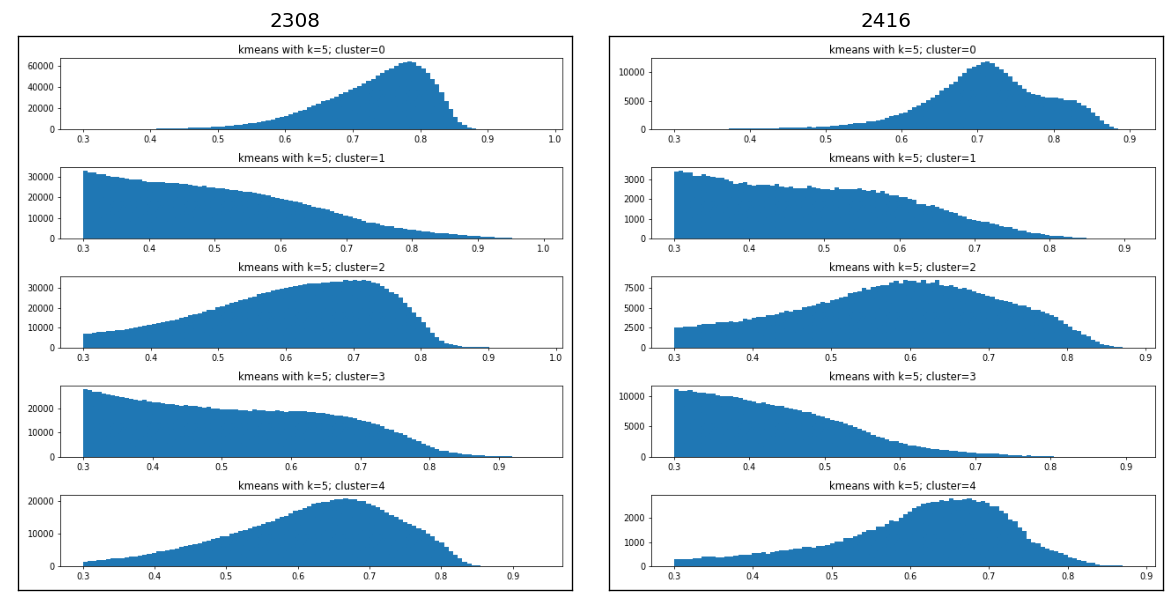

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(1,2,dpi=120, figsize=(10,5))
ax = ax.flatten()

for i, district in enumerate(districts):
    ax[i].imshow(mpimg.imread(f"{PREDICTIONS_DIR}/{model}_{n}_{dataset}_{district}/{model}_{n}_{dataset}_{district}.png"))

for i, dist in enumerate(districts):   
    ax[i].set_title(dist)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

plt.tight_layout()  

/home/arogya/.conda/envs/poppy-linux/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/arogya/.conda/envs/poppy-linux/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/arogya/.conda/envs/poppy-linux/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

15091.0

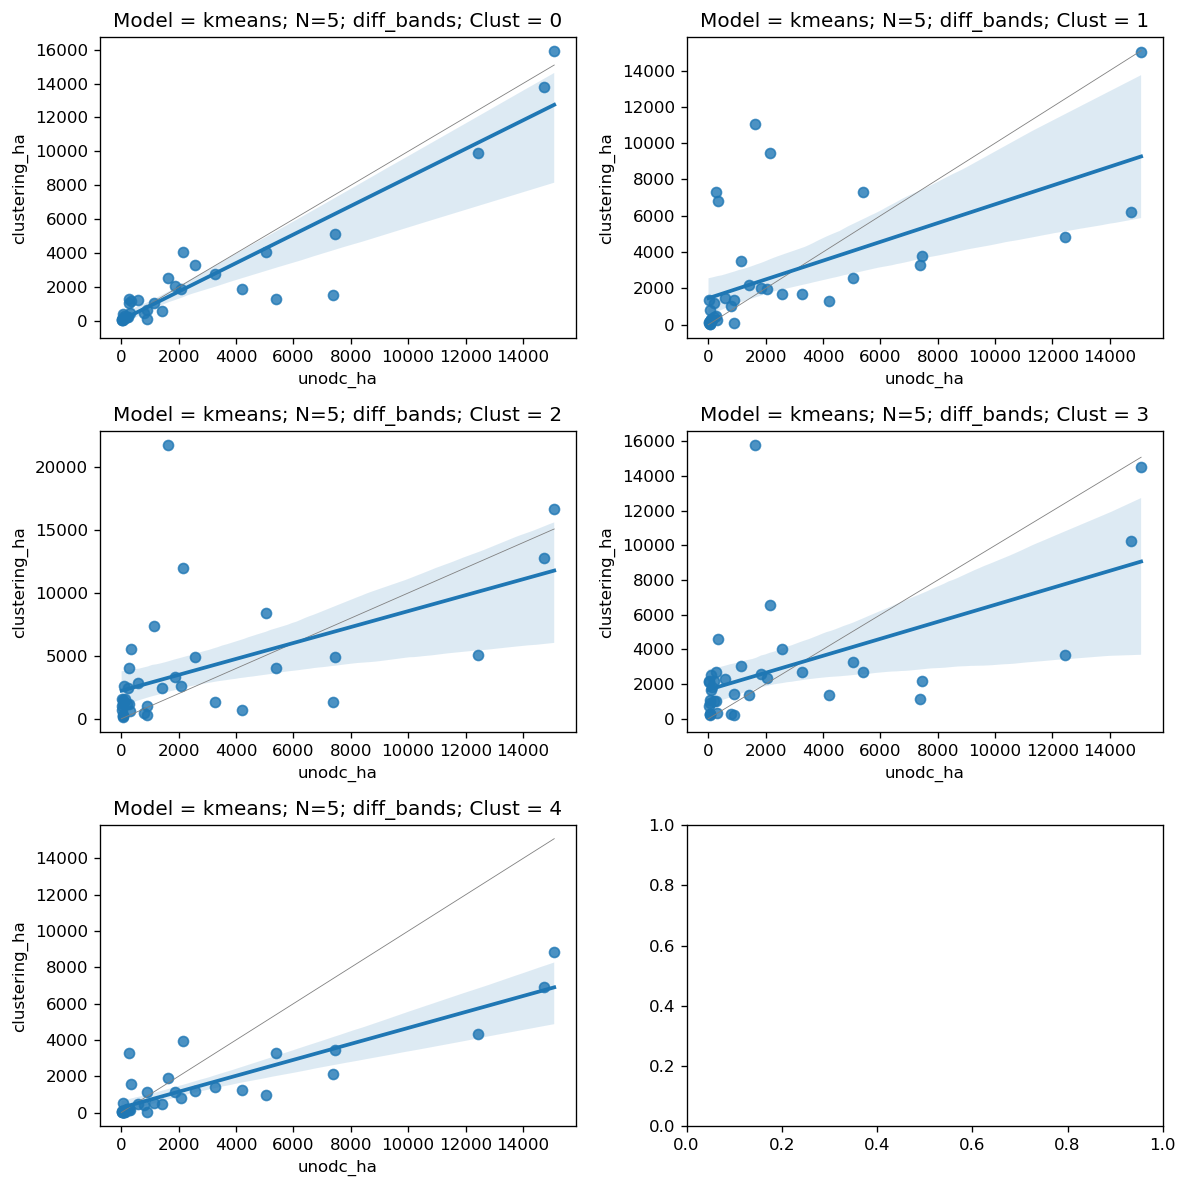

In [19]:
import seaborn as sns

def get_scatter(model, n, dataset):
    subset = all_results[all_results['model']==model ]
    subset = subset[subset['n'] == n]
    subset = subset[subset['dataset'] == dataset]
    
    nrows = int(n)//2 if int(n)%2 == 0 else int(n)//2 +1
    fig, ax = plt.subplots(nrows,2,dpi=120, figsize=(10,10))
    ax=ax.flatten()
    
    for i in range(0,int(n)):
        sub = subset[subset['clust'] == i]
        
        x = np.linspace(0,np.max(sub['unodc_ha']), 100)
        sns.lineplot(x,x,ax=ax[i], color='grey', linewidth=0.5 )

        sns.regplot(x=sub['unodc_ha'], y=sub['clustering_ha'], ax=ax[i])
        ax[i].set_title(f"Model = {model}; N={n}; {dataset}; Clust = {i}")
        
    plt.tight_layout()
    return np.max(subset['unodc_ha'])
#     return subset


get_scatter(model, n, dataset)

In [20]:
# sses = all_results.groupby(['model','n','dataset','clust']).sum()['yield_corrected_se'].reset_index()
# sses['n'] = sses['n'].astype(str)
# corrs['n'] = corrs['n'].astype(str)

# sse_corrs = pd.merge(sses, corrs)
# fig, ax = plt.subplots(1,1,dpi=120, figsize=(10,5))
# sns.scatterplot(x=sse_corrs['yield_corrected_se'], y=sse_corrs['pearson_correlation'], hue=sse_corrs['n'], ax=ax)